In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm

In [2]:
from scipy.stats import pearsonr,spearmanr

In [3]:
from gplearn.genetic import SymbolicRegressor,SymbolicTransformer
from gplearn import fitness
from gplearn.functions import make_function
from gplearn.fitness import make_fitness

In [4]:
# 截面分位数
def _rank(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        return np.nan_to_num((data_df.rank()/data_df.count()).values.reshape(-1))
    except:
        return np.zeros(len(data))

# 两组数据对应位置上的较大值
def _max(data1,data2):  
    try:
        return np.maximum(data1,data2)
    except:
        return np.zeros(len(data1))

# 两组数据对应位置上的较小值
def _min(data1,data2):  
    try:
        return np.minimum(data1,data2)
    except:
        return np.zeros(len(data1))

# 两组数据截面分位数之和
def _rank_add(data1,data2):
    try:
        data1_df=pd.DataFrame(data1.reshape(*event.shape)).replace(0,np.nan)
        data2_df=pd.DataFrame(data2.reshape(*event.shape)).replace(0,np.nan)
        rank1 = data1_df.rank()/data1_df.count()
        rank2 = data2_df.rank()/data2_df.count()
        value = rank1+rank2
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data1))

# 两组数据截面分位数之差
def _rank_sub(data1,data2):
    try:
        data1_df=pd.DataFrame(data1.reshape(*event.shape)).replace(0,np.nan)
        data2_df=pd.DataFrame(data2.reshape(*event.shape)).replace(0,np.nan)
        rank1 = data1_df.rank()/data1_df.count()
        rank2 = data2_df.rank()/data2_df.count()
        value = rank1-rank2
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data1))

# 两组数据截面分位数乘积
def _rank_mul(data1,data2):
    try:
        data1_df=pd.DataFrame(data1.reshape(*event.shape)).replace(0,np.nan)
        data2_df=pd.DataFrame(data2.reshape(*event.shape)).replace(0,np.nan)
        rank1 = data1_df.rank()/data1_df.count()
        rank2 = data2_df.rank()/data2_df.count()
        value = rank1*rank2
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data1))

# 两组数据截面分位数比值
def _rank_div(data1,data2):
    try:
        data1_df=pd.DataFrame(data1.reshape(*event.shape)).replace(0,np.nan)
        data2_df=pd.DataFrame(data2.reshape(*event.shape)).replace(0,np.nan)
        rank1 = data1_df.rank()/data1_df.count()
        rank2 = data2_df.rank()/data2_df.count()
        value = rank1/rank2
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data1))

# shift 1
def _delay1(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        return np.nan_to_num(data_df.shift(1,axis=1).values.reshape(-1))
    except:
        return np.zeros(len(data))

# shift 5
def _delay5(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        return np.nan_to_num(data_df.shift(5,axis=1).values.reshape(-1))
    except:
        return np.zeros(len(data))

# diff 1
def _delta1(data):  
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        return np.nan_to_num(data_df.diff(1,axis=1).values.reshape(-1))
    except:
        return np.zeros(len(data))

# rolling 5天取std
def _ts_std5(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value=data_df.rolling(5,min_periods=2,axis=1).std()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

# rolling 10天取std
def _ts_std10(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value=data_df.rolling(10,min_periods=5,axis=1).std()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

# rolling 5天取最小值
def _ts_min5(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value=data_df.rolling(5,min_periods=2,axis=1).min()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

# rolling 10天取最小值
def _ts_min10(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value=data_df.rolling(10,min_periods=5,axis=1).min()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

# rolling 5天取最大值
def _ts_max5(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value=data_df.rolling(5,min_periods=2,axis=1).max()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

# rolling 10天取最大值
def _ts_max10(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value=data_df.rolling(10,min_periods=5,axis=1).max()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

# rolling 10天取最小值
def _ts_cov10(data1, data2):
    try:
        data1_df=pd.DataFrame(data1.reshape(*event.shape)).replace(0,np.nan)
        data2_df=pd.DataFrame(data2.reshape(*event.shape)).replace(0,np.nan)
        value=data1_df.T.rolling(window=10, min_periods=5).cov(data2_df.T).T
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data1))

# 时序协方差
def _ts_cov5(data1, data2):
    try:
        data1_df=pd.DataFrame(data1.reshape(*event.shape)).replace(0,np.nan)
        data2_df=pd.DataFrame(data2.reshape(*event.shape)).replace(0,np.nan)
        value=data1_df.T.rolling(window=5, min_periods=2).cov(data2_df.T).T
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data1))

def _ts_corr10(data1, data2):
    try:
        data1_df=pd.DataFrame(data1.reshape(*event.shape)).replace(0,np.nan)
        data2_df=pd.DataFrame(data2.reshape(*event.shape)).replace(0,np.nan)
        value=data1_df.T.rolling(window=10, min_periods=5).corr(data2_df.T).T
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data1))

# 时序相关系数
def _ts_corr5(data1, data2):
    try:
        data1_df=pd.DataFrame(data1.reshape(*event.shape)).replace(0,np.nan)
        data2_df=pd.DataFrame(data2.reshape(*event.shape)).replace(0,np.nan)
        value=data1_df.T.rolling(window=5, min_periods=2).corr(data2_df.T).T
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data1))

# 时序 mean/std
def _ts_ms10(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        roll = data_df.rolling(window=10, min_periods=5,axis=1)
        value = roll.mean() / roll.std()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))
    
def _ts_ms5(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        roll = data_df.rolling(window=5, min_periods=2,aixs=1)
        value = roll.mean() / roll.std()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

# 时序z分数
def _ts_zscore10(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        roll = data_df.rolling(window=10, min_periods=5,axis=1)
        value = (data_df - roll.mean())/roll.std()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

def _ts_zscore5(data):
    try:
        data_df=pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        roll = data_df.rolling(window=5, min_periods=2,axis=1)
        value = (data_df - roll.mean())/roll.std()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

# 时序pct_change
def _ts_chg10(data):
    try:
        data_df = pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value = data_df.pct_change(10, axis=1)
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))
    
def _ts_chg5(data):
    try:
        data_df = pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value = data_df.pct_change(5, axis=1)
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))
    
def _ts_chg1(data):
    try:
        data_df = pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value = data_df.pct_change(1, axis=1)
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

# 时序偏度
def _ts_skew5(data):
    try:
        data_df = pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value = data_df.rolling(5,min_periods=2,axis=1).skew()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))
    
def _ts_skew10(data):
    try:
        data_df = pd.DataFrame(data.reshape(*event.shape)).replace(0,np.nan)
        value = data_df.rolling(10,min_periods=5,axis=1).skew()
        return np.nan_to_num(value.values.reshape(-1))
    except:
        return np.zeros(len(data))

rank=make_function(function=_rank,name='rank',arity=1)
max_=make_function(function=_max,name='max_',arity=2)
min_=make_function(function=_min,name='min_',arity=2)
rank_add=make_function(function=_rank_add,name='rank_add',arity=2)
rank_sub=make_function(function=_rank_sub,name='rank_sub',arity=2)
rank_mul=make_function(function=_rank_mul,name='rank_mul',arity=2)
rank_div=make_function(function=_rank_div,name='rank_div',arity=2)
delay1=make_function(function=_delay1,name='delay1',arity=1)
delay5=make_function(function=_delay5,name='delay5',arity=1)
delta1=make_function(function=_delta1,name='delta1',arity=1)
ts_std5=make_function(function=_ts_std5,name='ts_std5',arity=1)
ts_std10=make_function(function=_ts_std10,name='ts_std10',arity=1)
ts_min5=make_function(function=_ts_min5,name='ts_min5',arity=1)
ts_min10=make_function(function=_ts_min10,name='ts_min10',arity=1)
ts_max5=make_function(function=_ts_max5,name='ts_max5',arity=1)
ts_max10=make_function(function=_ts_max10,name='ts_max10',arity=1)
ts_cov10=make_function(function=_ts_cov10,name='ts_cov10',arity=2)
ts_cov5=make_function(function=_ts_cov5,name='ts_cov5',arity=2)
ts_corr10=make_function(function=_ts_corr10,name='ts_corr10',arity=2)
ts_corr5=make_function(function=_ts_corr5,name='ts_corr5',arity=2)
ts_ms10=make_function(function=_ts_ms10,name='ts_ms10',arity=1)
ts_ms5=make_function(function=_ts_ms5,name='ts_ms5',arity=1)
ts_zscore10=make_function(function=_ts_zscore10,name='ts_zscore10',arity=1)
ts_zscore5=make_function(function=_ts_zscore5,name='ts_zscore5',arity=1)
ts_chg10=make_function(function=_ts_chg10,name='ts_chg10',arity=1)
ts_chg5=make_function(function=_ts_chg5,name='ts_chg5',arity=1)
ts_chg1=make_function(function=_ts_chg1,name='ts_chg1',arity=1)
ts_skew10=make_function(function=_ts_skew10,name='ts_skew10',arity=1)
ts_skew5=make_function(function=_ts_skew5,name='ts_skew5',arity=1)

In [5]:
post=ff.read('post')
filter0=ff.filter0
close=ff.read('close')*post*filter0
open_=ff.read('open')*post*filter0
high=ff.read('high')*post*filter0
low=ff.read('low')*post*filter0
vol=ff.read('vol')*filter0
amount=ff.read('amount')*post*filter0

In [6]:
inds = pd.read_pickle('/mydata2/wangs/data/dict_ind_matrix_sw1.pk')

In [7]:
result = pd.DataFrame(columns=['因子','夏普率','收益率','mkt_'])

In [8]:
mkv=(ff.read('mkv','factor')*filter0).loc[close.index,'20200101':'20210101']
mkv_s=mkv.values.reshape(-1)

In [9]:
mkt20=close.shift(-10,axis=1)/close - 1

In [10]:
factor_names1=['closer', 'openr', 'lowr', 'highr', 'ocret', 'lcret', 'hcret', 'ohret', 'ret5', 'ret10', 'ret20', 'ret30', 'excess5', 'excess10', 'excess20', 'excess30', 'ma5', 'bias5', 'ma10',
               'bias10', 'ma15', 'bias15', 'ma20', 'bias20', 'vwap_ret', 'vwaph_ret', 'll5', 'll15', 'll20', 'll30', 'a0', 'a5', 'a15', 'a30', 'ah5', 'ah10', 'ah15', 'std', 'amt_std', 'vol_std', 
               'amt_mean', 'vol_mean', 'turnover', 'turnover_mean', 'turnover_std', 'turnover_skew', 'turnoverf', 'turnoverf_mean', 'turnoverf_std', 'turnoverf_skew', 'mkv', 'l_mkv', 'lhret', 
               'STR', 'MTR', 'SMTR', 'ILLIQ','close','high','low']
factor_names2=['ARRP', 'ARRP_5d_20mean', 'AmpMod', 'BVol', 'CDPDVP', 'ILLIQ', 'IVoldeCorr', 'IntraDayMom20', 'MTR', 'RCP', 'SMTR', 'SPS', 'STR', 'a30', 
               'afternoon_ratio_1', 'ah15', 'amt', 'amt_ma20', 'amt_mean', 'amt_score0', 'amt_score1', 'amt_score2', 'amt_std', 'amt_std20', 'bias10', 'bias15', 'bias20', 'bias5', 
               'cross_std10', 'cross_std10adj', 'ctrade', 'excess10', 'excess20', 'excess30', 'excess5', 'growth_a', 'growth_b', 'growth_c', 'h_rankamt_corr_10', 'h_rankv_corr_10', 'h_rankv_corr_36', 
               'hcret', 'idiov', 'intro_high80_corr', 'ivr', 'l_mkv', 'mkv', 'mom1', 'mom_spring', 'nl_mkv', 'nl_mom', 'open0931ratio', 'open5ratio_ma10vol', 'rank_2_corr_hv10', 'rank_2_corr_hv20', 'rank_ha_corr_sum', 
               'ret20', 'ret30', 'ret5', 'roc121', 'roc20', 'roc240', 'roc5', 'scr', 'std', 'std20', 'std21', 'std240', 'stddev_cov', 'stddev_cov_right', 'sub', 'sysv', 'tail_ratio_1', 'tailrets0', 'tailrets1', 'tliq', 
               'turn20', 'turnover', 'turnover_mean', 'turnover_scale_z', 'turnover_score_ts_mean', 'turnover_score_ts_std', 'turnover_skew', 'turnover_std', 'turnoverf', 'turnoverf_mean', 'turnoverf_skew', 'turnoverf_std', 
               'up_KURS', 'up_plus_down_KURS', 'vol', 'vol_mean', 'vol_std', 'vol_std20', 'volroc_skew', '滞后日内量价corr']
factor_names3 =['accelerated_turnover_rank_RC','CSK_XYY_UP_DOWN_120D_RC','high_fre_vol_RC','high_fre_diff_vol_RC','high_fre_absdiff_vol_RC','peak_count_vol_RC','overnightsmart20_RC','CTR_RC','jumpCTR_RC','turnover_rate_proportion_l','synergy']
factor_name4 = ['ll60','ll120', 'lr5', 'lr10', 'lr20', 'lr30','lr60','lr120','posi60','posi120','posi240','nhigh20','nhigh60', 'nhigh120','nhigh20','nhigh60','nhigh120']
fields = factor_names1 + factor_names2 + factor_names3

In [11]:
stock_test=pd.DataFrame()
for factor in fields:
    # stock_test[factor] = pd.DataFrame(ff.read(factor),index=open_.index,columns=ff.read('synergy').loc[:,'20200101':'20210101'].columns).values.reshape(-1)
    data = pd.DataFrame(ff.read(factor),index=open_.index,columns=ff.read('synergy').loc[:,'20200101':'20210101'].columns)
    stock_test[factor] = ((data - data.mean())/data.std()).values.reshape(-1)
test_code=[code for code in close.index for i in close.loc[:,'20200101':'20210101'].columns]
test_date=close.loc[:,'20200101':'20210101'].columns.to_list() *len(close.index)
stock_test['code']=test_code
stock_test['date']=test_date
stock_test['1'],stock_test['5'],stock_test['10'],stock_test['20'],stock_test['40'],stock_test['60']=1,5,10,20,40,60

In [12]:
stock_test

,closer,openr,lowr,highr,ocret,lcret,hcret,ohret,ret5,ret10,...,turnover_rate_proportion_l,synergy,code,date,1,5,10,20,40,60
0,0.396141,0.595843,0.765205,0.089252,0.077048,-0.068244,0.543840,-0.207893,0.049878,-0.033764,...,NaN,NaN,000001.SZ,20200102,1,5,10,20,40,60
1,0.643997,0.248272,1.073088,0.352641,0.533896,-0.028127,0.442930,0.256585,0.290946,0.167880,...,NaN,NaN,000001.SZ,20200103,1,5,10,20,40,60
2,-0.573952,-0.370435,-0.038946,-0.484705,-0.393708,-0.650287,-0.188688,-0.294918,-0.285140,-0.173245,...,NaN,NaN,000001.SZ,20200106,1,5,10,20,40,60
3,-0.376399,0.214922,0.060173,-0.446909,-0.554671,-0.526605,0.148680,-0.611098,-0.246689,-0.266652,...,NaN,NaN,000001.SZ,20200107,1,5,10,20,40,60
4,-0.599497,-0.415813,-0.376823,-0.746668,-0.441476,-0.526529,0.207214,-0.607352,-0.271305,-0.395370,...,NaN,NaN,000001.SZ,20200108,1,5,10,20,40,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,T00018.SH,20201225,1,5,10,20,40,60
1346945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,T00018.SH,20201228,1,5,10,20,40,60
1346946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,T00018.SH,20201229,1,5,10,20,40,60
1346947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,T00018.SH,20201230,1,5,10,20,40,60


In [13]:
# test_mkt=mkt20.loc[:,'20200101':'20210101'].values.reshape(-1)
test_mkt=(mkt20.loc[:,'20200101':'20210101'].rank()/mkt20.loc[:,'20200101':'20210101'].count()).values.reshape(-1)

In [14]:
import statsmodels.api as sm

def rankIC_metric(y,y_pred,w=None):
    
    def cal_rankIC(df):
        df.index=df.code
        # 去极值
        M=df.y_pred.mean()    #df.y_pred.median()
        M1=df.y_pred.std()    #(df.y_pred-M).abs().median()
        df.y_pred.loc[df.y_pred>M+3*M1]=M+3*M1    #5
        df.y_pred.loc[df.y_pred<M-3*M1]=M-3*M1
        # 行业市值中性化
        day=df.date.iloc[0]
        ind=inds[day].copy()
        ind['mkv']=df.loc[ind.index,'mkv']
        input_x=ind.dropna().astype(float)
        input_y=df.loc[input_x.index,'y_pred']
        y_true=df.loc[input_x.index,'y'].values
        if len(input_x)==0:
            return 0
        else:
            mod=sm.OLS(input_y,input_x)
            res=mod.fit()
            y_adj=res.resid
            #标准化
            y_adj=(y_adj-y_adj.mean())/y_adj.std()
        
            if len(np.unique(y_adj.values)) <=2:
                return 0
            else:
                #return y_adj.corr(input_xy.mkt_delay,method='spearman')
                return spearmanr(np.nan_to_num(y_adj.values),np.nan_to_num(y_true))[0]
            
    if len(np.unique(y_pred))<=2:
        return 0
    else:
        try:
            data=pd.DataFrame({'y_pred':y_pred,'y':y,'mkv':np.log(mkv_s),'code':test_code,'date':test_date})
            res=data.groupby('date').apply(cal_rankIC)
            return np.abs(np.nanmean(res))
        except:
            return 0

In [15]:
rankIC=make_fitness(function=rankIC_metric,greater_is_better=True)

In [16]:
function_set = ['add','sub','mul','div','sqrt','log','inv','abs','neg',rank,max_,min_,rank_add,rank_sub,rank_mul,rank_div,delay1,delay5,delta1,ts_std5,ts_std10,ts_min5,ts_min10,ts_max5,ts_max10,ts_cov10,ts_cov5,ts_corr10,ts_corr5,ts_ms10,ts_ms5,ts_zscore10,ts_zscore5,ts_chg10,ts_chg5,ts_chg1,ts_skew10,ts_skew5]

In [17]:
test_gp=SymbolicTransformer(feature_names = fields,
                            function_set = function_set, #所有算子
                            generations = 3, #进化代数
                            population_size = 500, #种群规模
                            tournament_size = 10, #竞标赛规模
                            p_crossover=0.4,
                            p_subtree_mutation=0.05,
                            p_hoist_mutation=0.01,
                            p_point_mutation=0.03,
                            p_point_replace=0.35,
                            init_depth=(1,4),
                            const_range = None,
                            metric=rankIC,
                            parsimony_coefficient = 'auto',
                            low_memory=True,
                            verbose=2,
                            n_jobs = 6)

In [18]:
import psutil
import os
print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 ** 3) )
info = psutil.virtual_memory()
print(u'电脑总内存：%.4f GB' % (info.total / 1024 ** 3))
print(u'当前使用的总内存占比：', info.percent)
print(u'cpu个数：', psutil.cpu_count())

当前进程的内存使用：8.1680 GB
电脑总内存：1007.4503 GB
当前使用的总内存占比： 43.1
cpu个数： 256


In [19]:
test_gp.fit(np.nan_to_num(stock_test.loc[:,fields].values),np.nan_to_num(test_mkt))

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:  1.0min remaining:  2.0min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  1.3min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


   0     4.31       0.00781581        3        0.0733319              N/A      2.69m


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:  2.2min remaining:  4.3min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  4.3min finished


   1     4.16        0.0386905        3        0.0733319              N/A      4.27m


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:  4.7min remaining:  9.3min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  6.1min finished


   2     3.59        0.0649721        5        0.0875988              N/A      0.00s


SymbolicTransformer(const_range=None,
                    feature_names=['closer', 'openr', 'lowr', 'highr', 'ocret',
                                   'lcret', 'hcret', 'ohret', 'ret5', 'ret10',
                                   'ret20', 'ret30', 'excess5', 'excess10',
                                   'excess20', 'excess30', 'ma5', 'bias5',
                                   'ma10', 'bias10', 'ma15', 'bias15', 'ma20',
                                   'bias20', 'vwap_ret', 'vwaph_ret', 'll5',
                                   'll15', 'll20', 'll30', ...],
                    function_set=['add', 'sub', 'mul', 'div', 'sqrt...
                                  <gplearn.functions._Function object at 0x7f734edd88b0>,
                                  <gplearn.functions._Function object at 0x7f734edd87f0>, ...],
                    generations=3, init_depth=(1, 4), low_memory=True,
                    metric=<gplearn.fitness._Fitness object at 0x7f72e8dfbc70>,
                    n_jobs=6, p_crossover=0.4, p_point_mutation=0.03,
                    p_point_replace=0.35, p_subtree_mutation=0.05,
                    parsimony_coefficient='auto', population_size=100,
                    tournament_size=10, verbose=2)

In [20]:
stock_all=pd.DataFrame()
for factor in fields:
    stock_all[factor] = pd.DataFrame(ff.read(factor),index=open_.index,columns=ff.read('synergy').loc[:,'20200101':'20240101'].columns).values.reshape(-1)
test_code=[code for code in close.index for i in close.loc[:,'20200101':'20240101'].columns]
test_date=close.loc[:,'20200101':'20240101'].columns.to_list() *len(close.index)
stock_all['code']=test_code
stock_all['date']=test_date
stock_all['1'],stock_all['5'],stock_all['10'],stock_all['20'],stock_all['40'],stock_all['60']=1,5,10,20,40,60

Program 1: max_(add(ret20, turnoverf), ARRP_5d_20mean)
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


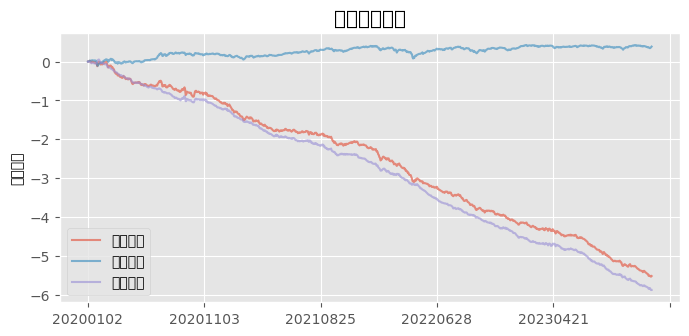

,指数收益,超额收益,策略收益
年化收益率,0.099,-1.513,-1.420
年化波动率,0.201,0.225,0.326
夏普率,0.495,-6.719,-4.353
最大回撤,-0.325,-5.923,-5.549
收益回撤比,0.305,-0.255,-0.256
胜率,0.534,0.324,0.398
盈亏比,0.948,0.678,0.729


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


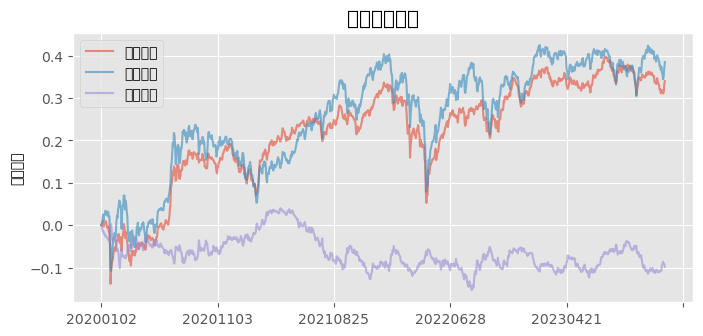

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.025,0.088
年化波动率,0.201,0.102,0.152
夏普率,0.495,-0.249,0.575
最大回撤,-0.325,-0.193,-0.285
收益回撤比,0.305,-0.131,0.308
胜率,0.534,0.464,0.523
盈亏比,0.948,1.106,1.013


Program 2: min_(turnoverf_std, ts_min5(sub(vol_mean, overnightsmart20_RC)))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


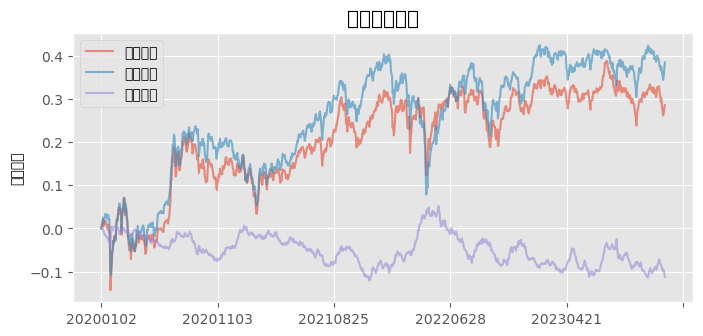

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.029,0.074
年化波动率,0.201,0.077,0.199
夏普率,0.495,-0.378,0.371
最大回撤,-0.325,-0.167,-0.196
收益回撤比,0.305,-0.174,0.375
胜率,0.534,0.468,0.532
盈亏比,0.948,1.065,0.937


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


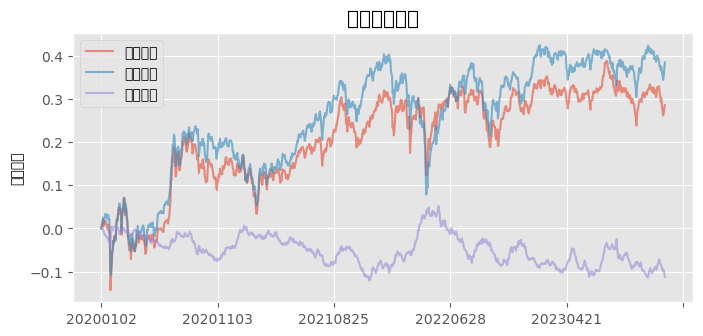

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.029,0.074
年化波动率,0.201,0.077,0.199
夏普率,0.495,-0.378,0.371
最大回撤,-0.325,-0.167,-0.196
收益回撤比,0.305,-0.174,0.375
胜率,0.534,0.468,0.532
盈亏比,0.948,1.065,0.937


Program 3: min_(turnoverf_std, add(tliq, bias5))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


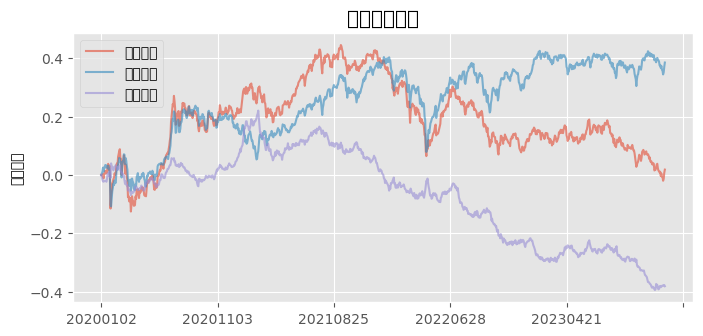

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.098,0.005
年化波动率,0.201,0.115,0.215
夏普率,0.495,-0.854,0.022
最大回撤,-0.325,-0.615,-0.466
收益回撤比,0.305,-0.160,0.010
胜率,0.534,0.472,0.508
盈亏比,0.948,0.968,0.969


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


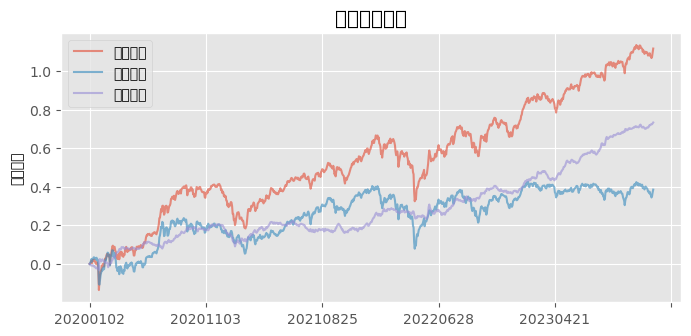

,指数收益,超额收益,策略收益
年化收益率,0.099,0.189,0.288
年化波动率,0.201,0.088,0.221
夏普率,0.495,2.155,1.305
最大回撤,-0.325,-0.115,-0.342
收益回撤比,0.305,1.651,0.843
胜率,0.534,0.528,0.564
盈亏比,0.948,1.292,0.967


Program 4: add(turnover_std, sqrt(low))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


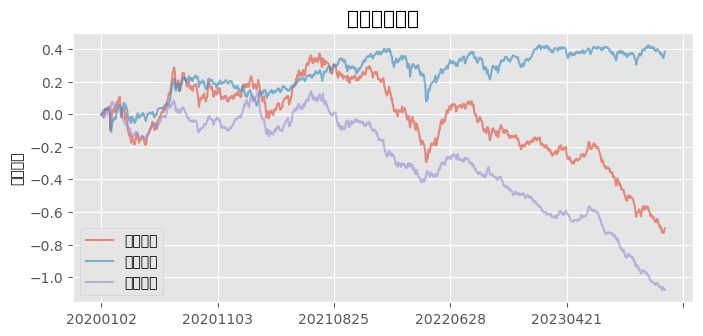

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.278,-0.181
年化波动率,0.201,0.178,0.277
夏普率,0.495,-1.561,-0.653
最大回撤,-0.325,-1.223,-1.103
收益回撤比,0.305,-0.227,-0.164
胜率,0.534,0.460,0.493
盈亏比,0.948,0.905,0.922


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


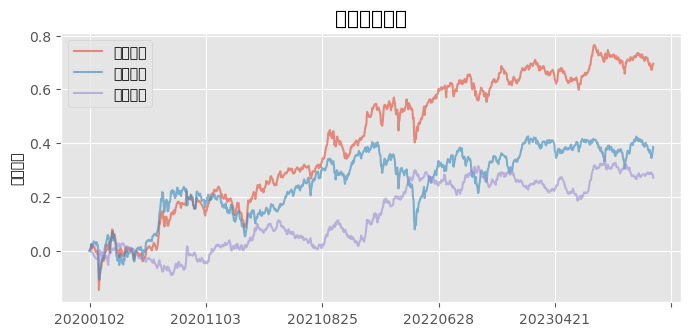

,指数收益,超额收益,策略收益
年化收益率,0.099,0.070,0.179
年化波动率,0.201,0.120,0.186
夏普率,0.495,0.586,0.961
最大回撤,-0.325,-0.129,-0.170
收益回撤比,0.305,0.543,1.055
胜率,0.534,0.493,0.540
盈亏比,0.948,1.131,1.007


Program 5: synergy
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


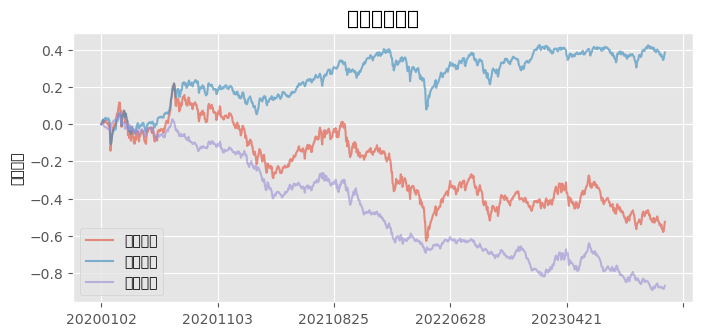

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.224,-0.135
年化波动率,0.201,0.165,0.298
夏普率,0.495,-1.361,-0.454
最大回撤,-0.325,-0.953,-0.847
收益回撤比,0.305,-0.235,-0.160
胜率,0.534,0.447,0.513
盈亏比,0.948,0.983,0.877


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


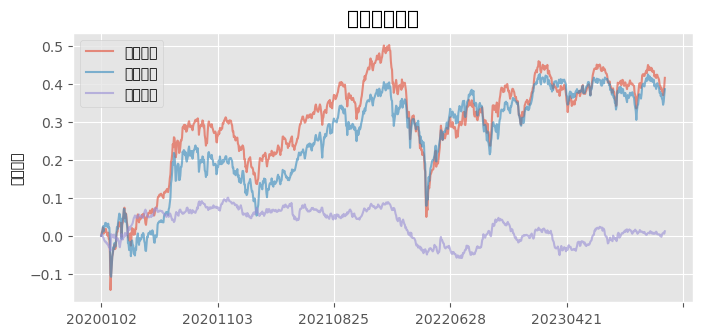

,指数收益,超额收益,策略收益
年化收益率,0.099,0.003,0.107
年化波动率,0.201,0.076,0.192
夏普率,0.495,0.040,0.559
最大回撤,-0.325,-0.159,-0.452
收益回撤比,0.305,0.019,0.237
胜率,0.534,0.480,0.534
盈亏比,0.948,1.087,0.961


Program 6: neg(rank_2_corr_hv10)
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


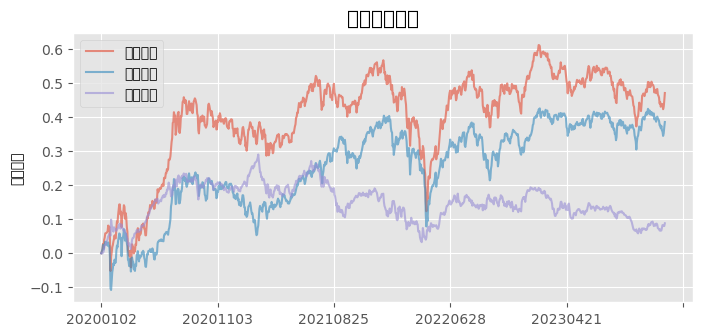

,指数收益,超额收益,策略收益
年化收益率,0.099,0.023,0.121
年化波动率,0.201,0.122,0.238
夏普率,0.495,0.186,0.510
最大回撤,-0.325,-0.257,-0.444
收益回撤比,0.305,0.088,0.273
胜率,0.534,0.503,0.542
盈亏比,0.948,1.018,0.919


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


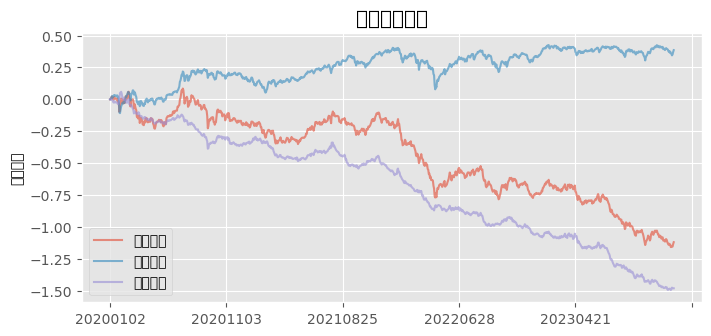

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.381,-0.288
年化波动率,0.201,0.150,0.275
夏普率,0.495,-2.548,-1.049
最大回撤,-0.325,-1.552,-1.242
收益回撤比,0.305,-0.246,-0.232
胜率,0.534,0.435,0.486
盈亏比,0.948,0.849,0.887


Program 7: neg(CSK_XYY_UP_DOWN_120D_RC)
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


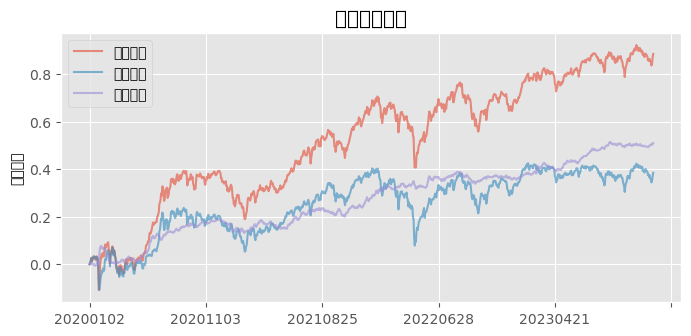

,指数收益,超额收益,策略收益
年化收益率,0.099,0.132,0.228
年化波动率,0.201,0.073,0.225
夏普率,0.495,1.809,1.017
最大回撤,-0.325,-0.078,-0.299
收益回撤比,0.305,1.694,0.763
胜率,0.534,0.541,0.571
盈亏比,0.948,1.157,0.891


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


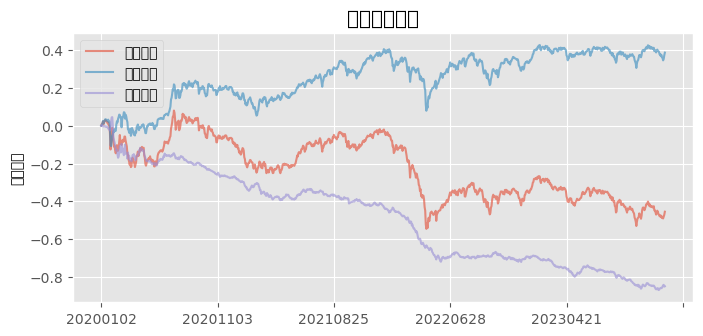

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.219,-0.117
年化波动率,0.201,0.110,0.220
夏普率,0.495,-1.988,-0.533
最大回撤,-0.325,-0.912,-0.624
收益回撤比,0.305,-0.240,-0.188
胜率,0.534,0.434,0.502
盈亏比,0.948,0.881,0.903


Program 8: min_(turnoverf_std, ret5)
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


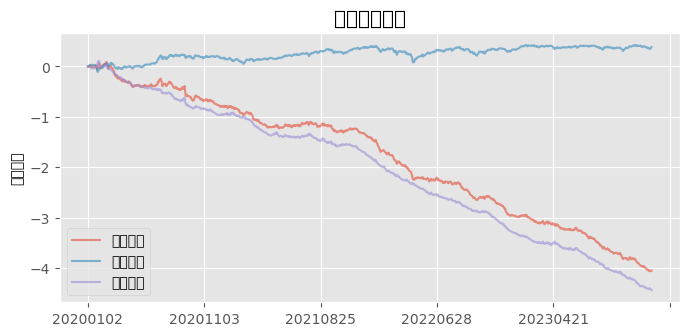

,指数收益,超额收益,策略收益
年化收益率,0.099,-1.144,-1.044
年化波动率,0.201,0.196,0.281
夏普率,0.495,-5.827,-3.719
最大回撤,-0.325,-4.551,-4.156
收益回撤比,0.305,-0.251,-0.251
胜率,0.534,0.337,0.419
盈亏比,0.948,0.745,0.745


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


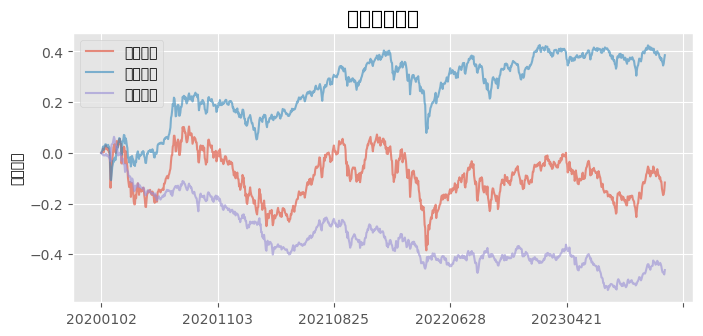

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.119,-0.030
年化波动率,0.201,0.147,0.287
夏普率,0.495,-0.813,-0.105
最大回撤,-0.325,-0.605,-0.489
收益回撤比,0.305,-0.197,-0.062
胜率,0.534,0.467,0.519
盈亏比,0.948,0.995,0.910


Program 9: min_(vwap_ret, synergy)
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


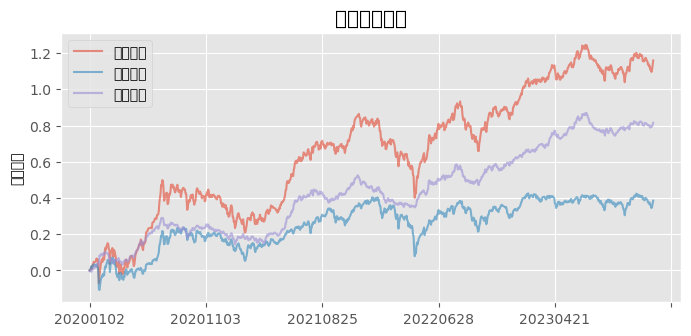

,指数收益,超额收益,策略收益
年化收益率,0.099,0.210,0.299
年化波动率,0.201,0.130,0.280
夏普率,0.495,1.613,1.067
最大回撤,-0.325,-0.178,-0.463
收益回撤比,0.305,1.183,0.645
胜率,0.534,0.535,0.562
盈亏比,0.948,1.135,0.931


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


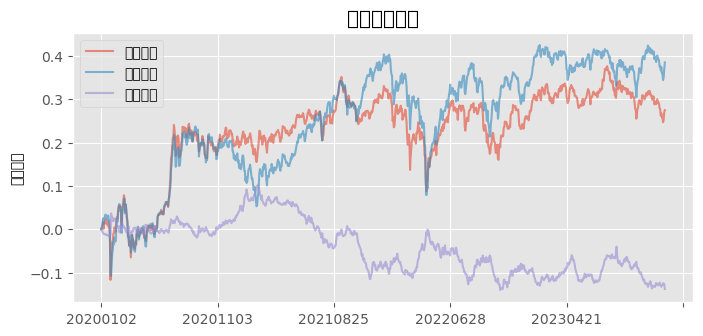

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.036,0.071
年化波动率,0.201,0.088,0.185
夏普率,0.495,-0.402,0.384
最大回撤,-0.325,-0.243,-0.264
收益回撤比,0.305,-0.146,0.268
胜率,0.534,0.462,0.529
盈亏比,0.948,1.087,0.952


Program 10: max_(min_(excess20, high_fre_absdiff_vol_RC), add(log(turnoverf_mean), ts_chg10(excess5)))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


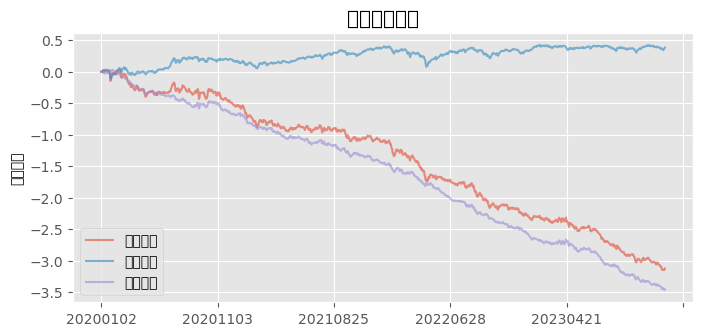

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.891,-0.805
年化波动率,0.201,0.221,0.342
夏普率,0.495,-4.037,-2.354
最大回撤,-0.325,-3.500,-3.185
收益回撤比,0.305,-0.255,-0.253
胜率,0.534,0.394,0.453
盈亏比,0.948,0.786,0.817


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


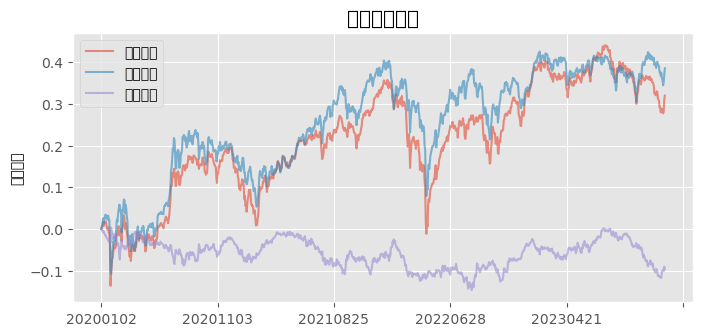

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.025,0.082
年化波动率,0.201,0.095,0.183
夏普率,0.495,-0.262,0.451
最大回撤,-0.325,-0.150,-0.369
收益回撤比,0.305,-0.166,0.223
胜率,0.534,0.463,0.527
盈亏比,0.948,1.108,0.972


In [21]:
transformed_factor = []
for i, program in enumerate(test_gp._best_programs):
    print(f'Program {i+1}: {program}')
    transformed_X = program.execute(np.nan_to_num(stock_all.loc[:,fields].values))
    transformed_factor_X = pd.DataFrame(transformed_X.reshape(close.shape[0],-1),index = close.index,columns = close.loc[:,'20200101':'20240101'].columns)
    a = ff.run(-transformed_factor_X*ff.filter0.loc[:,'20200101':'20240101'], positions = 100, period = 1, fees = 0)[0]
    b = ff.run(transformed_factor_X*ff.filter0.loc[:,'20200101':'20240101'], positions = 100, period = 1, fees = 0)[0]
    if a.iloc[0,2] > 0:
        result.loc[len(result)] = ('-'+str(program),a.iloc[2,2],a.iloc[0,2],10)
    else:
        result.loc[len(result)] = (str(program),b.iloc[2,2],b.iloc[0,2],10)